# Importing Modules

In [1]:
import torch
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Train And Test Sets

In [2]:
class_names=['covid','normal','viral']
main_dir='COVID-19 Radiography Database'
source_dirs=['NORMAL','Viral Pneumonia','COVID-19']

In [3]:
class covid_dataset(torch.utils.data.Dataset):
    
    def __init__(self,dir,transforms):
        # dir is a list of class names and directory path 
        def get_images(class_name):
            images=[x for x in os.listdir(dir[class_name]) if (x[-3:].lower().endswith('png'))]
            return images
        
        self.images={}
        self.class_names=['normal','covid','viral']
        
        for class_name in self.class_names:
            self.images[class_name]=get_images(class_name) # get the images of that class 
        
        self.img_dirs=dir
        self.transform=transforms
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self,index):
        
        class_name=random.choice(self.class_names)
        index=index%len(self.images[class_name])
        image_name=self.images[class_name][index]
        image_path=os.path.join(self.img_dirs[class_name],image_name)
        image=Image.open(image_path).convert('RGB')
        return self.transform(image),self.class_names.index(class_name)        

In [4]:
# directories containing images for training purposes
train_dirs={
    'viral':'./COVID-19 Radiography Database/Viral Pneumonia',
    'normal':'./COVID-19 Radiography Database/NORMAL',
    'covid':'./COVID-19 Radiography Database/COVID-19'
}

test_dirs={
    'viral':'COVID-19 Radiography Database/test/viral',
    'normal':'COVID-19 Radiography Database/test/normal',
    'covid':'COVID-19 Radiography Database/test/covid'
}

In [5]:
import torchvision

In [6]:
# transform using torchvision

train_transforms=torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transforms=torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485,0.456,0.404],[0.229,0.224,0.225])
])

In [7]:
train_dataset=covid_dataset(train_dirs,train_transforms)
test_dataset=covid_dataset(test_dirs,test_transforms)

In [8]:
batch_size=6

train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

# Model Training And Results

In [9]:
model=torchvision.models.resnet18(pretrained=True)

In [10]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
model.fc=torch.nn.Linear(in_features=512,out_features=3)

In [12]:
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr =3e-5)

In [13]:
len(next(iter(train_dataloader))[0])

6

In [14]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
epochs=1 #2
history=[]

In [16]:
# Training
for i in range(1,epochs+1):
    train_loss=0
    val_loss=0
    model.train()
    for steps,(images,labels) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output=model(images)
        loss=loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        history.append(loss.item())
        print("The loss after {} iteration / {} epoch is :{}".format(steps+1,i,loss.item()))
        if ((steps+1)%20==0):
            accuracy = 0
            model.eval() # set model to eval phase
            for val_step, (images, labels) in enumerate(test_dataloader):
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                accuracy += sum((preds == labels).numpy())

            val_loss /= (val_step + 1)
            accuracy = accuracy/len(test_dataset)
            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
            model.train()
            if accuracy >= 0.95:
                print('Performance condition satisfied, stopping..')
                break

The loss after 1 iteration / 1 epoch is :1.888289451599121
The loss after 2 iteration / 1 epoch is :1.2364624738693237
The loss after 3 iteration / 1 epoch is :1.8769035339355469
The loss after 4 iteration / 1 epoch is :0.9834191203117371
The loss after 5 iteration / 1 epoch is :0.8914548754692078
The loss after 6 iteration / 1 epoch is :0.9258820414543152
The loss after 7 iteration / 1 epoch is :0.5701814293861389
The loss after 8 iteration / 1 epoch is :0.7302501201629639
The loss after 9 iteration / 1 epoch is :0.8064798712730408
The loss after 10 iteration / 1 epoch is :0.7253347039222717
The loss after 11 iteration / 1 epoch is :1.196332573890686
The loss after 12 iteration / 1 epoch is :0.46310654282569885
The loss after 13 iteration / 1 epoch is :1.0090230703353882
The loss after 14 iteration / 1 epoch is :0.5944228172302246
The loss after 15 iteration / 1 epoch is :0.5425912141799927
The loss after 16 iteration / 1 epoch is :0.440902978181839
The loss after 17 iteration / 1 epo

The loss after 131 iteration / 1 epoch is :0.6377818584442139
The loss after 132 iteration / 1 epoch is :0.203676238656044
The loss after 133 iteration / 1 epoch is :0.02322114072740078
The loss after 134 iteration / 1 epoch is :0.19632305204868317
The loss after 135 iteration / 1 epoch is :0.2893323600292206
The loss after 136 iteration / 1 epoch is :0.07712813466787338
The loss after 137 iteration / 1 epoch is :0.0953887403011322
The loss after 138 iteration / 1 epoch is :0.03724544867873192
The loss after 139 iteration / 1 epoch is :0.31986692547798157
The loss after 140 iteration / 1 epoch is :0.0813034400343895
Validation Loss: 0.1655, Accuracy: 0.9222
The loss after 141 iteration / 1 epoch is :0.19019831717014313
The loss after 142 iteration / 1 epoch is :0.7235308289527893
The loss after 143 iteration / 1 epoch is :0.017097415402531624
The loss after 144 iteration / 1 epoch is :0.18816594779491425
The loss after 145 iteration / 1 epoch is :0.3590686023235321
The loss after 146 i

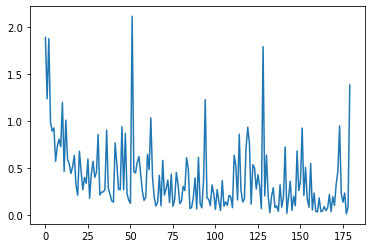

In [17]:
plt.plot(history)

In [18]:
image_paths = ["./aunti.jpg","./shimpu.jpg"]

In [22]:
def predict(image_path):
    image=Image.open(image_path).convert('RGB')
    image_tensor=test_transforms(image)
    image_tensor=image_tensor.unsqueeze_(0)
    out=model(image_tensor)
    print(out)
    _,pred=torch.max(out,1)
    plt.imshow(image)
    print(class_names[pred])

tensor([[-0.5110,  0.2170, -0.3200]], grad_fn=<AddmmBackward>)
normal
tensor([[-0.5288,  0.2356, -0.2944]], grad_fn=<AddmmBackward>)
normal


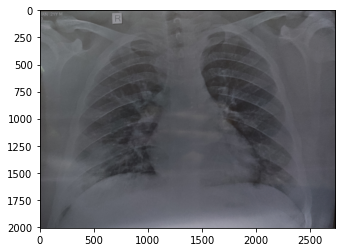

In [23]:
for image_path in image_paths:
    predict(image_path)

In [21]:
# save the model for future uses
torch.save(model.state_dict(),"model.pt")